# generate lists of words to explain the clusters

### Feb 8 2020, Brendan Chambers

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

import hdbscan
import umap

import os
import time
import random
import re

import spacy
from gensim.models import Word2Vec

from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus


In [2]:
### control params

In [3]:
#path2clusteredPMIDs = 'data_processing_feb2020/abstracts_2018_250k.json'
#model_dir = 'data_processing_feb2020/titles_2018_250k'

path2clusteredPMIDs = 'data_processing_feb2020/abstracts_2018_50k.json'
model_dir = 'data_processing_feb2020/abstracts_2018_50k'


In [4]:
## number of samples
with open(path2clusteredPMIDs, 'r') as f:
    data = json.load(f)
N_samples = len(data['pmids'])

dir_files = os.listdir(model_dir)

samples = {}
for i_sample in range(N_samples):
    model_names = []
    for f in dir_files:
        if '.model' in f:
            if '_{}_'.format(i_sample) in f:
                modelpath = os.path.join(model_dir, f)
                model_names.append(modelpath)

    model_names = sorted(model_names)  # sort by order of sample, order of cluster
    short_names = []
    for path in model_names:
        print(path)
        
        short_name = str.split(path,'/')[-1]
        print(short_name)
        short_names.append(short_name)
    print('-----------')
        
    samples[i_sample] = {}
    samples[i_sample]['model_names'] = model_names
    samples[i_sample]['short_names'] = short_names


data_processing_feb2020/abstracts_2018_25k/abstracts_0_cluster0_2018_25k.model
abstracts_0_cluster0_2018_25k.model
data_processing_feb2020/abstracts_2018_25k/abstracts_0_cluster1_2018_25k.model
abstracts_0_cluster1_2018_25k.model
data_processing_feb2020/abstracts_2018_25k/abstracts_0_cluster2_2018_25k.model
abstracts_0_cluster2_2018_25k.model
-----------
data_processing_feb2020/abstracts_2018_25k/abstracts_1_cluster0_2018_25k.model
abstracts_1_cluster0_2018_25k.model
data_processing_feb2020/abstracts_2018_25k/abstracts_1_cluster1_2018_25k.model
abstracts_1_cluster1_2018_25k.model
data_processing_feb2020/abstracts_2018_25k/abstracts_1_cluster2_2018_25k.model
abstracts_1_cluster2_2018_25k.model
-----------
data_processing_feb2020/abstracts_2018_25k/abstracts_2_cluster0_2018_25k.model
abstracts_2_cluster0_2018_25k.model
data_processing_feb2020/abstracts_2018_25k/abstracts_2_cluster1_2018_25k.model
abstracts_2_cluster1_2018_25k.model
data_processing_feb2020/abstracts_2018_25k/abstracts_2_c

### load in word2vec models trained on each coarse cluster

In [5]:
# temp, recreate the list of file names without re-training the w2v models

for i_sample in range(N_samples):
    print("sample {}".format(i_sample))
    print('---------')
    
    #models = {}
    for i_name, model_name in enumerate(samples[i_sample]['model_names']):

        short_name = samples[i_sample]['short_names'][i_name]
        print(short_name)

        model = Word2Vec.load(model_name)
        samples[i_sample][short_name] = {}
        samples[i_sample][short_name]['w2v_model'] = model
        #models[short_name] = model
        print('{} words '.format(len(model.wv.vocab)))  # length of the vocab dict
        print()
    

sample 0
---------
abstracts_0_cluster0_2018_25k.model
8855 words 

abstracts_0_cluster1_2018_25k.model
4503 words 

abstracts_0_cluster2_2018_25k.model
9349 words 

sample 1
---------
abstracts_1_cluster0_2018_25k.model
8968 words 

abstracts_1_cluster1_2018_25k.model
4257 words 

abstracts_1_cluster2_2018_25k.model
9630 words 

sample 2
---------
abstracts_2_cluster0_2018_25k.model
7822 words 

abstracts_2_cluster1_2018_25k.model
4468 words 

abstracts_2_cluster2_2018_25k.model
9291 words 



number of pmids: 5792
number of pmids: 2107
number of pmids: 6495
number of pmids: 5758
number of pmids: 1942
number of pmids: 6795
number of pmids: 4859
number of pmids: 2112
number of pmids: 6479


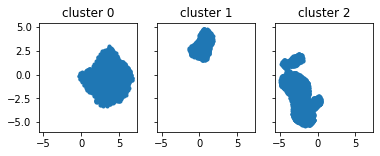

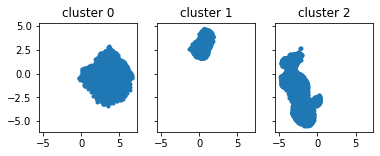

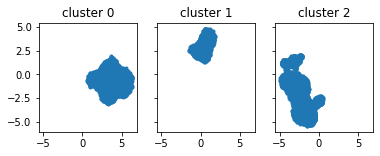

In [6]:
# re-plot the clusters to verify which is which
    
with open(path2clusteredPMIDs,'r') as f:
    data = json.load(f)
    pmids = data['pmids']
    summary_coords = data['summary_coords']
    
sample_IDs = [k for k in pmids.keys()]

for i_sample, sample in enumerate(sample_IDs):  # todo automate number of samples detection

    clusters = [k for k in pmids[sample].keys()]
    N_COL, N_ROW = len(clusters), 1
    fig, axs = plt.subplots(N_ROW, N_COL, sharex='all', sharey='all',
                               figsize=(6,2))

    for i_cluster, cluster in enumerate(clusters):
        print('number of pmids: {}'.format(len(summary_coords[sample][cluster])))
        xx = [p[0] for p in summary_coords[sample][cluster]]
        yy = [p[1] for p in summary_coords[sample][cluster]]

        axs[int(i_cluster)].scatter(xx,
                               yy,
                              marker='.')
        axs[int(i_cluster)].set_title('cluster {}'.format(i_cluster))

In [7]:
# build a networkx graph for each word similarity network

number of dimensions D: 20
dimensions: (8855, 8855)
--------------
number of dimensions D: 20
dimensions: (4503, 4503)
--------------
number of dimensions D: 20
dimensions: (9349, 9349)
--------------
number of dimensions D: 20
dimensions: (8968, 8968)
--------------
number of dimensions D: 20
dimensions: (4257, 4257)
--------------
number of dimensions D: 20
dimensions: (9630, 9630)
--------------
number of dimensions D: 20
dimensions: (7822, 7822)
--------------
number of dimensions D: 20
dimensions: (4468, 4468)
--------------
number of dimensions D: 20
dimensions: (9291, 9291)
--------------


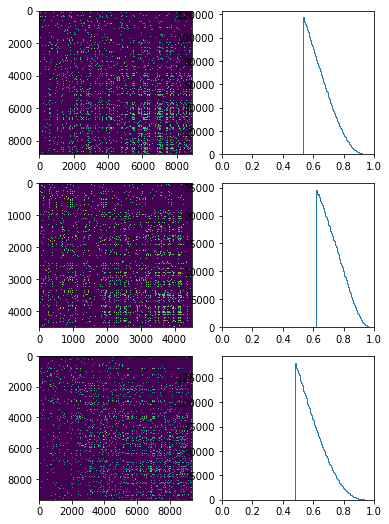

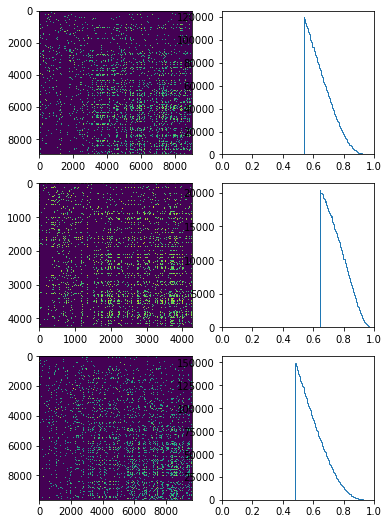

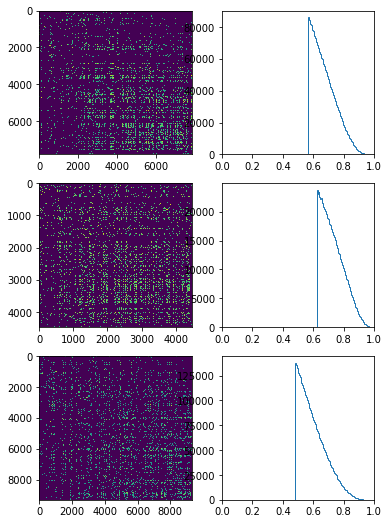

In [8]:
## todo use unique vocabularies for starters

for i_sample, sample in enumerate(sample_IDs):

    # todo should we match vocabulary sizes?
    clusters = samples[i_sample]['model_names']
    N_COL, N_ROW = 2, len(clusters)
    fig, axs = plt.subplots(N_ROW, N_COL, sharex='none', sharey='none',
                               figsize=(6,9))

    nx_graphs = []
    for idx, model_name in enumerate(samples[i_sample]['short_names']):

        model = samples[i_sample][model_name]['w2v_model']

        # the number of nodes is small so we can do this with naive mat mul, nothing clever needed

        D = np.shape(model.wv['data'])[0] # dimensionality of a sample word, any word will do
        print("number of dimensions D: {}".format(D))

        embedding_samples = np.zeros( (len(model.wv.vocab), D) )

        # collect samples
        for i_word, word in enumerate(model.wv.vocab):
            embedding_samples[i_word,:] = model.wv[word] 
        # demean
        for i_word, word in enumerate(model.wv.vocab):
            embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
        # normalize all vectors to the hypersphere
        for i_row,row in enumerate(embedding_samples):
            embedding_samples[i_row,:] /= np.linalg.norm(row,2)
        # compute edge weights via cosine similarity (projection of normalized vectors)
        W = np.matmul(embedding_samples, embedding_samples.T)
        # threshold and clean adjmat
        np.fill_diagonal(W, 0)  # no self-loops
        P_thresh = 90
        thresh_high = np.percentile(W.flatten(), P_thresh)
        boolean_mask = W < thresh_high
        W[boolean_mask] = 0 # 
        print("dimensions: {}".format(np.shape(W)))

        axs[idx,0].imshow(W, # [:300,:300],
                         aspect='auto')
        #axs[0,idx].colorbar()
        axs[idx,1].hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),
                        histtype='step',
                        bins=100)
        axs[idx,1].set_xlim([0,1])
        
        print('--------------')

        G_nx = nx.from_numpy_matrix(W)  # convert to graph for centrality computation
        nx.set_node_attributes(G_nx,
                               dict((i,w) for i,w in enumerate(model.wv.vocab)),
                               'word')
        d_eigcent = nx.eigenvector_centrality(G_nx, max_iter=200)
        nx.set_node_attributes(G_nx, d_eigcent, 'eigenvector_centrality')
        nx_graphs.append(G_nx)

        samples[i_sample][model_name]['G_nx'] = G_nx
        samples[i_sample][model_name]['P_thresh'] = P_thresh  # edge threshold on cosine scores

computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------
computing num triangles...
fetching adjmat...
computing cuthull mckee ordering...
finished.
--------


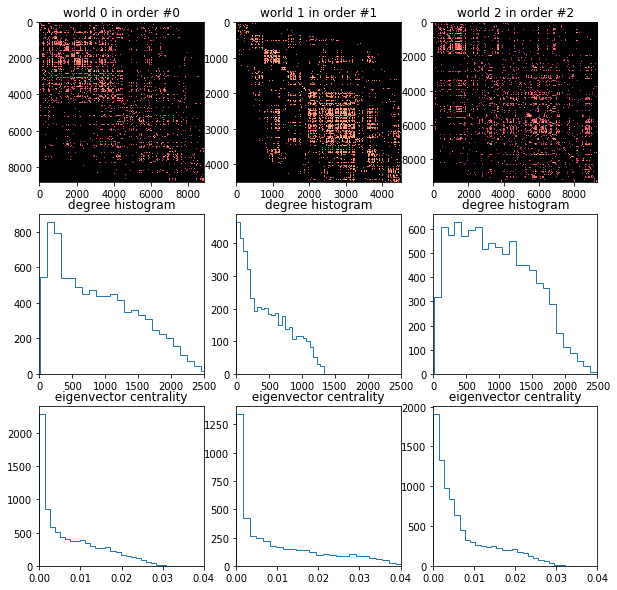

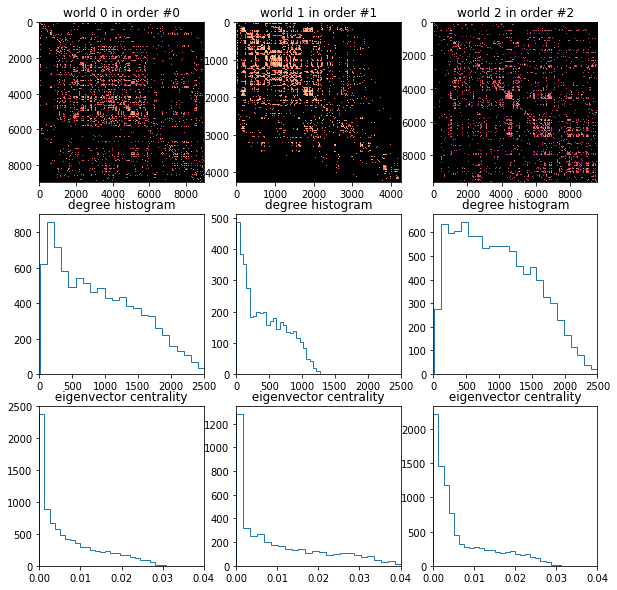

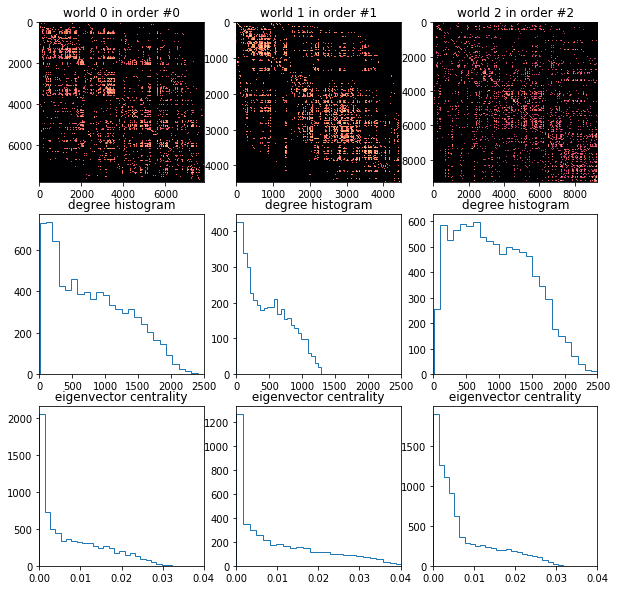

In [9]:
# plot the adjmats

for i_sample, sample in enumerate(sample_IDs):
    
     # todo should we match vocabulary sizes?
    clusters = samples[i_sample]['model_names']
    (f, ax) = plt.subplots(len(clusters),
                           3,
                           figsize=(10,10))

    community_results = []
    for idx, model_name in enumerate(samples[i_sample]['short_names']):
    #for idx, G in enumerate(nx_graphs):
        G = samples[i_sample][model_name]['G_nx']

        print('computing num triangles...')
        #communities = nx.algorithms.community.label_propagation_communities(G)
        #community_results.append([x for x in communities])

        print('fetching adjmat...')
        W = nx.convert_matrix.to_numpy_matrix(G)
        print('computing cuthull mckee ordering...')
        rcm = list(nx.utils.cuthill_mckee_ordering(G)) # pick the smallest to define the ordering
        print('finished.')

        W = nx.convert_matrix.to_numpy_matrix(G, nodelist=rcm)
        ax[0,idx].imshow(W, aspect='auto', cmap='magma')
        ax[0,idx].set_title('world {} in order #{}'.format(idx, idx))

        degrees = [d for n,d in G.degree()]

        #ax[0,idx].imshow(W,aspect='auto')
        #ax[0,idx].set_title('world {}'.format(idx))

        #ax[1,idx].set_ylim(bottom=0)
        ax[1,idx].hist(degrees, bins=25, histtype='step')
        ax[1,idx].set_title('degree histogram')
        ax[1,idx].set_xlim([0,2500])

        '''
        d_triangles = nx.get_node_attributes(G,'triangles')
        ax[2,idx].hist([count for count in d_triangles.values()], bins=25, histtype='step')
        ax[2,idx].set_title('triangles histogram')
        ax[2,idx].set_xlim([0,80000])
        '''

        d_eigcent = nx.get_node_attributes(G, 'eigenvector_centrality')
        ax[2,idx].hist([count for count in d_eigcent.values()], bins=25, histtype='step')
        ax[2,idx].set_title(' eigenvector centrality ')
        ax[2,idx].set_xlim([0,0.04])
        
        samples[i_sample][model_name]['G_nx'] = G  # is this redundant?
        
        print('--------')

    plt.savefig('figures_2/network_worlds_overview.pdf')
    plt.savefig('figures_2/network_worlds_overview.png')

computing cuthull mckee ordering...
finished.
computing cuthull mckee ordering...
finished.
computing cuthull mckee ordering...
finished.


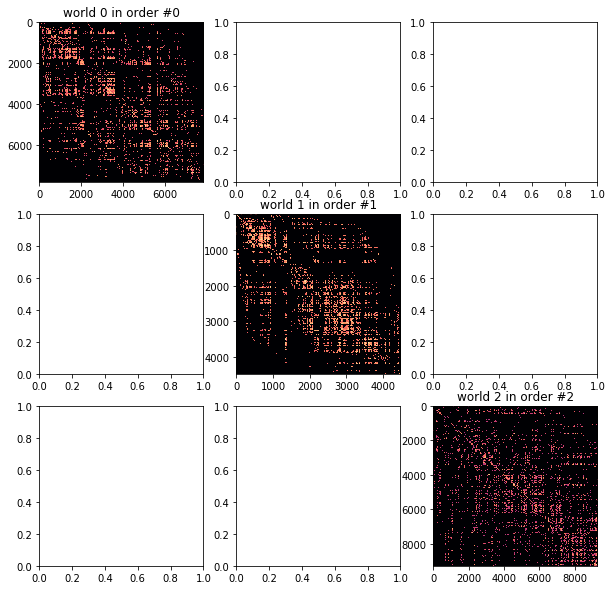

In [10]:
# plot each adjmat in cuthill-mckee order (for the first sample)

# todo orient the overview plot horizontally instead (mimicking the plot above)

clusters = samples[0]['model_names']
(f, ax) = plt.subplots(len(clusters),
                       len(clusters),
                       figsize=(10,10))

for reference_id in range(len(clusters)):
    
    print('computing cuthull mckee ordering...')
    rcm = list(nx.utils.cuthill_mckee_ordering(nx_graphs[reference_id])) # pick the smallest to define the ordering
    print('finished.')

    W = nx.convert_matrix.to_numpy_matrix(nx_graphs[reference_id], nodelist=rcm)
    ax[reference_id,reference_id].imshow(W, aspect='auto', cmap='magma')
    ax[reference_id,reference_id].set_title('world {} in order #{}'.format(reference_id, reference_id))

#plt.savefig('cuthill_mckee.pdf')
#plt.savefig('cuthill_mckee.png')
    

In [11]:
### helper function

In [17]:
def id_eigcentral_nodes(sample_id, cluster_id, export_prefix, model_dir):
    '''
    for sample set specified by model_dir
    for sample id := sample id
    for cluster of pmids within the sample cluster_id
    using name identifier := export prefix
    
    plot+save high eigenvector central nodes
    plot+save the network of their interconnections
    export the list of central words & corresponding node_ids
    '''

    # todo incorporate sample_id
    model_name = samples[sample_id]['short_names'][cluster_id]
    G_thresh = samples[sample_id][model_name]['G_nx']
    
    print('fetching node attributes...')
    d_eigcent = nx.get_node_attributes(G_thresh,'eigenvector_centrality')
    d_words = nx.get_node_attributes(G_thresh, 'word')

    # sort ascending
    top_nodes = [t[0] for t in sorted(d_eigcent.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_eigcent.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]

    top_words = [d_words[i] for i in top_nodes]  # idxs -> words

    # print
    K = int(np.floor(0.015 * len(scores)))
    print(top_nodes[:K])
    print(top_words[:K])

    plt.figure()
    plt.plot(scores[:K],color='r')
    plt.plot(scores, color=[0,0,0,0.25], linestyle=':')
    
    plt.savefig('figures_2/eigscores {} s{} c{}.png'.format(export_prefix,
                                                            sample_id,
                                                            cluster_id))
    plt.savefig('figures_2/eigscores {} s{} c{}.pdf'.format(export_prefix,
                                                            sample_id,
                                                            cluster_id))

    node_subset = top_nodes[:K]            
    G = G_thresh.subgraph(node_subset)    
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    #print('fetching node attributes...')
    #d_eigcent = nx.get_node_attributes(nx_graphs[cluster_id],'eigenvector_centrality')

    print('generating labels...')
    labels = dict( (node,top_words[i]) for i,node in enumerate(G.nodes()))
    
    print('computing layout...')
    #d_layout_full = nx.spring_layout(nx_graphs[cluster_id]) # .subgraph(top_nodes[:2000]))  # TEMP cutoff for prototyping
    #d_layout = {k: d_layout_full[k] for k in top_nodes[:K]}
    #d_layout = {k: d_layout_full[k] for k in all_neighbors}
    #d_layout = nx.random_layout(G)
    d_layout = nx.spring_layout(G)
    print('layout finished')

    SCALE = 10000
    node_sizes = SCALE*np.array([f for f in scores])
    
    print('plotting...')
    plt.figure()
    nx.draw(G,
           pos=d_layout, # s[idx],  #d_layout
           with_labels=False,
           node_color=[[0.1,0.3,0.2,0.1]],
           node_size=node_sizes, #  labels=labels,
           edgelist=edges,
           edge_color=weights,
           width=0.25,
           edge_cmap=plt.cm.Blues) 
    
    plt.savefig('figures_2/layout {} s{} c{}.png'.format(export_prefix,
                                                         sample_id,
                                                         cluster_id))
    plt.savefig('figures_2/layout {} s{} c{}.pdf'.format(export_prefix,
                                                         sample_id,
                                                         cluster_id))
    save_obj = {'eigcentral_nodes': top_nodes,
                'eigcentral_words': top_words}
    save_path = "{}/centrality s{} c{}.json".format(model_dir,
                                                     sample_id,
                                                     cluster_id)
    with open(save_path,'w') as f:
        json.dump(save_obj, f)

In [13]:
# old version
def plot_eigcent_nodes(cluster_id):
    
    d_eigcent = nx.get_node_attributes(nx_graphs[cluster_id],'eigenvector_centrality')
    d_words = nx.get_node_attributes(nx_graphs[cluster_id], 'word')

    # sort ascending
    top_nodes = [t[0] for t in sorted(d_eigcent.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    scores = [t[1] for t in sorted(d_eigcent.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]

    top_words = [d_words[i] for i in top_nodes]  # idxs -> words

    # print
    K = int(np.floor(0.015 * len(scores)))
    print(top_nodes[:K])
    print(top_words[:K])

    plt.figure()
    plt.plot(scores[:K],color='r')
    plt.plot(scores, color=[0,0,0,0.25], linestyle=':')
    
    plt.savefig('figures_2/eigscores {}.png'.format(cluster_id))
    plt.savefig('figures_2/eigscores {}.pdf'.format(cluster_id))

    node_subset = top_nodes[:K]
    '''
    print('crawling neighborhood...')
    all_neighbors = []
    for i,node in enumerate(node_subset):
        all_neighbors.append(node)
        for neighbor in nx_graphs[cluster_id][node]:
            all_neighbors.append(neighbor)
    all_neighbors = list(set(all_neighbors))
    print('{} neighbors fetched'.format(len(all_neighbors)))
    '''
    all_neighbors = node_subset
            
    #G = nx_graphs[cluster_id].subgraph(node_subset)
    G = nx_graphs[cluster_id].subgraph(all_neighbors)
    
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    #print(weights)

    print('fetching node attributes...')
    d_eigcent = nx.get_node_attributes(nx_graphs[cluster_id],'eigenvector_centrality')

    print('generating labels...')
    labels = dict( (node,top_words[i]) for i,node in enumerate(G.nodes()))
    
    print('computing layout...')
    d_layout_full = nx.spring_layout(nx_graphs[cluster_id]) # .subgraph(top_nodes[:2000]))  # TEMP cutoff for prototyping
    #d_layout = {k: d_layout_full[k] for k in top_nodes[:K]}
    d_layout = {k: d_layout_full[k] for k in all_neighbors}
    #d_layout = nx.random_layout(G)
    print('layout finished')

    SCALE = 10000
    node_sizes = SCALE*np.array([f for f in scores])
    
    print('plotting...')
    plt.figure()
    nx.draw(G,
           pos=d_layout, # s[idx],  #d_layout
           with_labels=False,
           node_color=[[0.1,0.3,0.2,0.1]],
           node_size=node_sizes, #  labels=labels,
           edgelist=edges,
           edge_color=weights,
           width=0.25,
           edge_cmap=plt.cm.Blues) 
    
    plt.savefig('figures_2/layout {}.png'.format(cluster_id))
    plt.savefig('figures_2/layout {}.pdf'.format(cluster_id))
    
    plt.show()


-------------------
sample: 0

sample 0 cluster 0
fetching node attributes...
[8428, 6470, 5925, 6150, 7776, 6987, 7125, 5691, 5622, 4426, 5818, 7341, 7446, 7777, 7769, 4400, 7510, 7693, 7871, 8534, 4473, 7242, 5115, 4845, 8020, 6475, 7692, 6157, 6491, 8088, 6806, 7079, 5512, 7538, 8205, 8295, 8601, 7940, 8797, 4388, 8136, 6591, 8415, 5692, 8000, 7331, 8827, 8567, 8156, 8196, 6484, 7632, 8456, 4768, 7437, 6675, 6031, 7977, 8400, 7430, 5710, 8248, 6651, 6426, 8083, 7631, 4243, 6074, 7281, 5671, 8796, 6974, 8725, 6105, 8668, 4829, 8051, 6894, 5929, 7838, 6355, 7829, 6474, 6279, 4225, 7212, 8314, 7732, 7861, 8585, 8180, 7175, 4944, 7414, 5999, 7755, 4239, 8721, 8105, 6895, 6672, 6545, 7141, 7946, 7014, 7063, 4905, 7122, 7291, 6021, 4556, 8001, 8446, 8100, 3738, 7207, 4433, 6428, 5709, 7527, 8214, 8154, 7795, 8514, 4830, 5090, 7181, 7329, 7500, 7691, 7517, 5178]
['gr', 'lysine', 'ash', 'alpha', 'polychlorinated', 'dc', 'laying', 'lactate', 'burning', 'vessels', 'sod', 'mares', 'spray', 'p

generating labels...
computing layout...
layout finished
plotting...

sample 1 cluster 1
fetching node attributes...
[2737, 2533, 2840, 3947, 3721, 2113, 4046, 3392, 2868, 3238, 3087, 4109, 3550, 3201, 3134, 2927, 2307, 4008, 1946, 3473, 2860, 3992, 2449, 2174, 2381, 4108, 3566, 3549, 3535, 3101, 3595, 3389, 3431, 3217, 2926, 3693, 3745, 2526, 4068, 1144, 2567, 2566, 1373, 1767, 492, 3062, 3746, 3864, 3003, 4125, 3121, 3741, 3854, 2675, 3899, 3706, 3590, 1659, 3418, 3530, 3648, 3691, 3654]
['circulating', 'axonal', 'meniscus', 'tdp43', 'uv', 'behaviors', 'venlafaxine', 'hs', 'sulfate', 'ph', 'cd177', 'kel', 'typical', 'mutation', 's', 'layer', 'variant', 'preference', 'peptide', 'csf', 'nerve', 'hcv', 'antibody', 'plaques', 'formula', 'transfusion', 'gi', 'complete', 'ai', 'glycation', 'lupus', 'sucrose', 'na', 'remodelling', 'rpe', 'newborn', 'exercise', 'lesions', 'axon', 'synovial', 'versus', 'cartilage', 'mechanical', 'bpa', 'urinary', 'hypoxic', 'gingival', 'ccfc', 'pb', 'spreadin

generating labels...
computing layout...
layout finished
plotting...


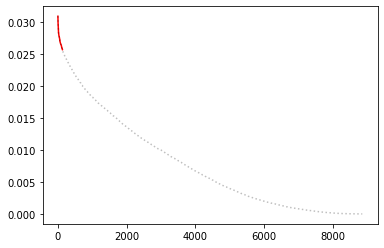

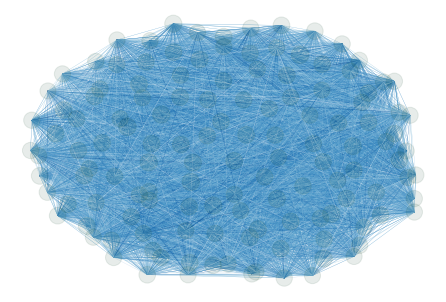

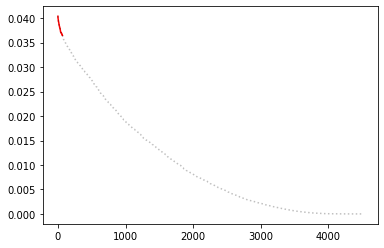

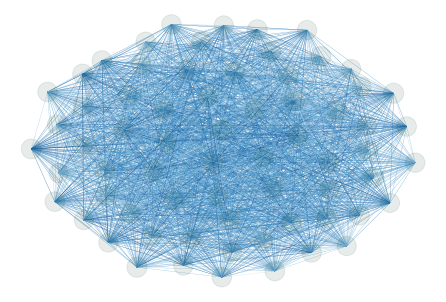

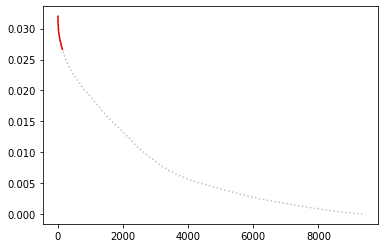

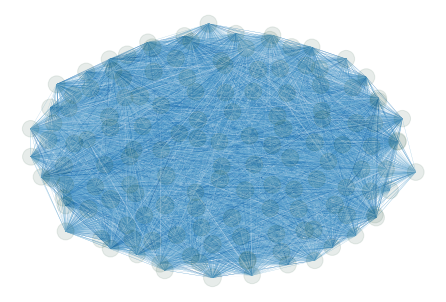

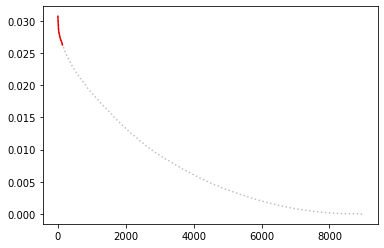

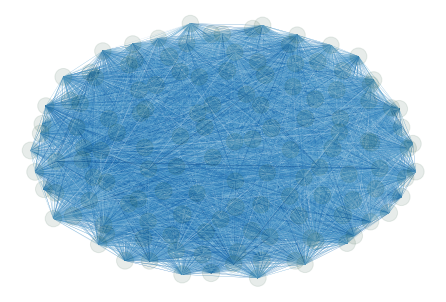

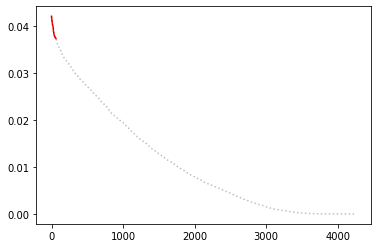

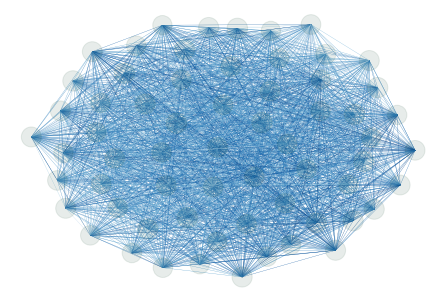

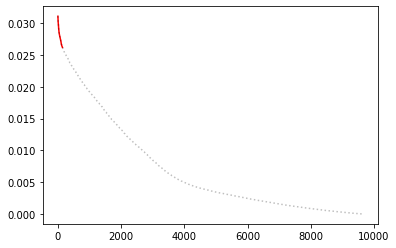

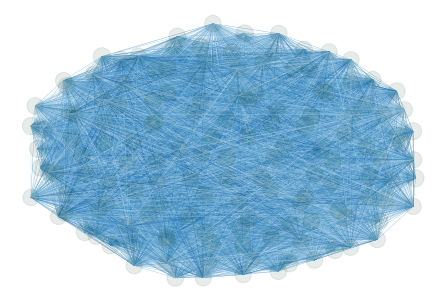

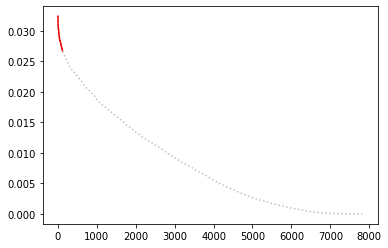

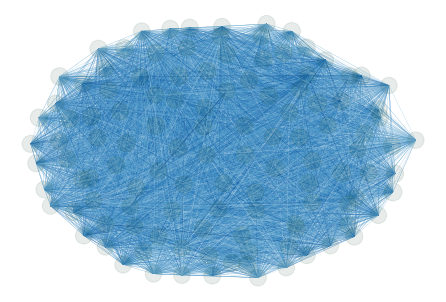

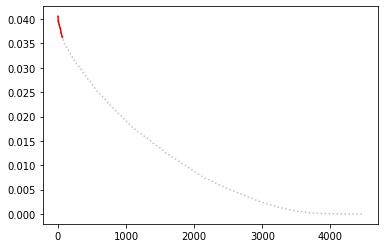

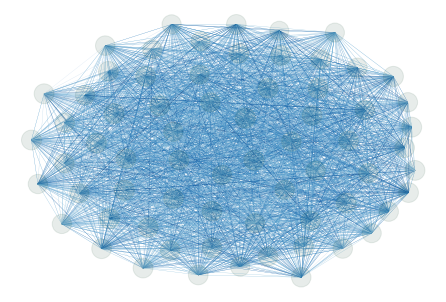

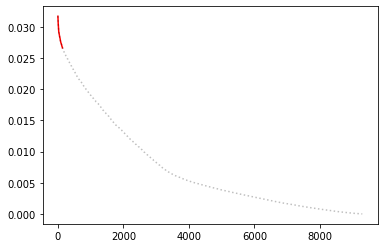

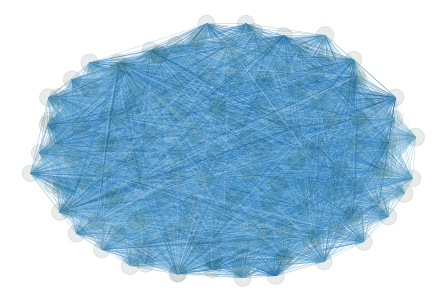

In [20]:
export_prefix = str.split(model_dir,'/')[-1] # grab the postfix

for sample_id in range(N_samples):
    print()
    print('-------------------')
    print('sample: {}'.format(sample_id))
    N_clusters = len(samples[sample_id]['model_names'])
    
    for cluster_id in range(N_clusters):
        print()
        print('sample {} cluster {}'.format(sample_id, cluster_id))
        id_eigcentral_nodes(sample_id, cluster_id, export_prefix, model_dir)
        

In [ ]:
cluster_id = 0
plot_eigcent_nodes(cluster_id)

In [ ]:
cluster_id = 1
plot_eigcent_nodes(cluster_id)

In [ ]:
cluster_id = 2
plot_eigcent_nodes(cluster_id)


In [ ]:
for i_sample in range(N_samples):
    
    N_clusters = len(clusters = samples[i_sample]['model_names'])
    for i_cluster in range(N_clusters):
        
        #  plot_eigcent_nodes(cluster_id)
        